In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        
    def __load__(self, id_name):
        ## Path
        
        image_path = os.path.join(self.path, id_name)
        
        ## Reading Images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ## Normalizaing 
        image = image/255.0
        
        return image
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        name = []
        
        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img)
            name.append(id_name)
            
        image = np.array(image)
        
        return image
    
    def __getitemname__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        name = []
        
        for id_name in files_batch:
            name.append(id_name)
        
        return name
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 256

sel_dat = "Dataset_Nei"

train_path = "dataset/" + sel_dat + "/Segmentazione/ISIC2018_Task1-2_Validation_Input"

batch_size = 10

## Training Ids
train_ids = next(os.walk(train_path))
train_ids = train_ids[2:][0]
random.shuffle(train_ids)

valid_ids = train_ids

In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [5]:
img_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

In [11]:
model = UNet()

## Load the Weights
model.load_weights("UNetW-"+ str(image_size)+".h5")
model.load_weights("UNetW.h5")

## Dataset for prediction
x = img_gen.__getitem__(0)
name = img_gen.__getitemname__(0)

for i in range(1,len(img_gen)):
    x = np.concatenate((x, img_gen.__getitem__(i)))
    name += img_gen.__getitemname__(i)

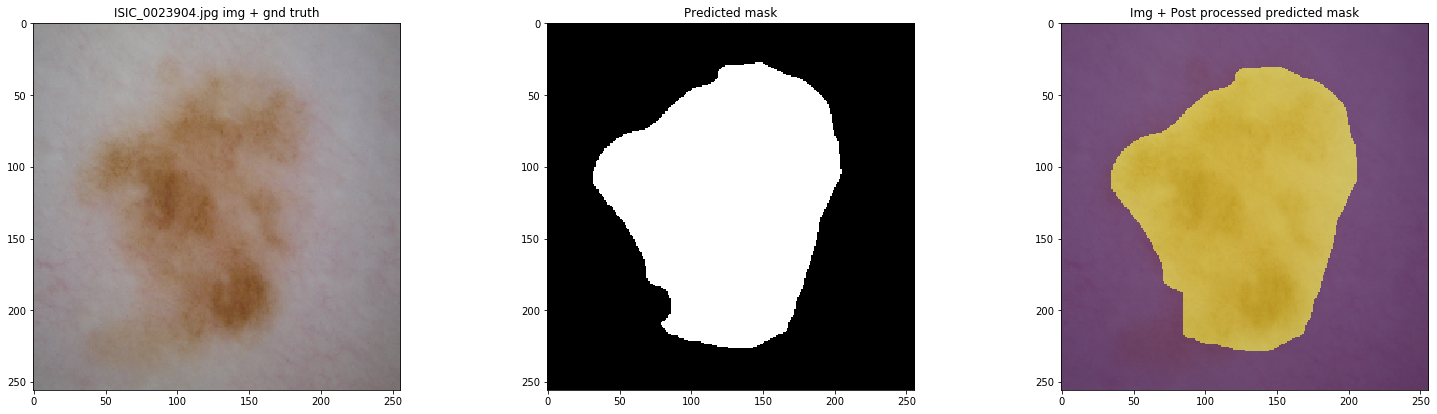

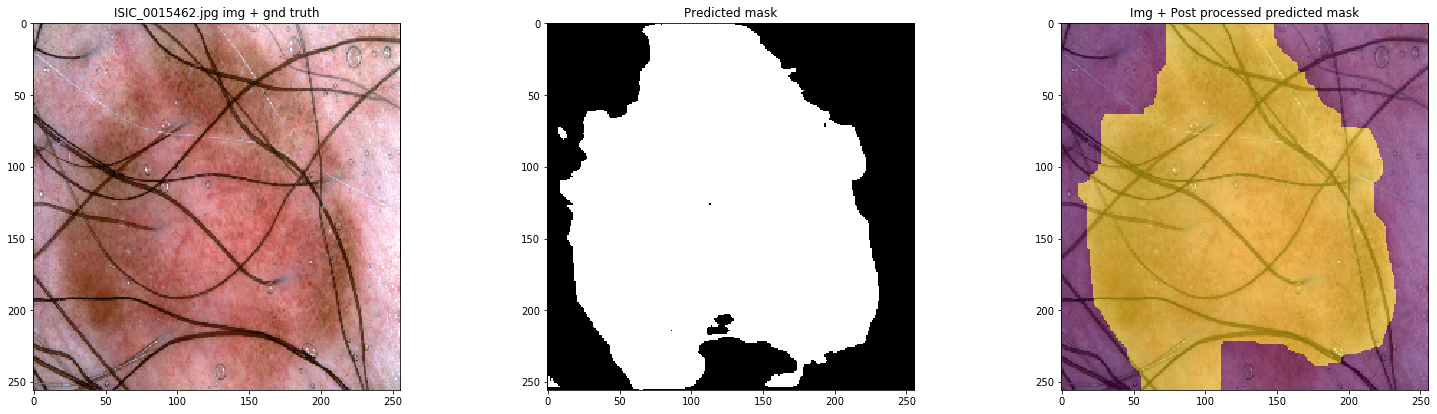

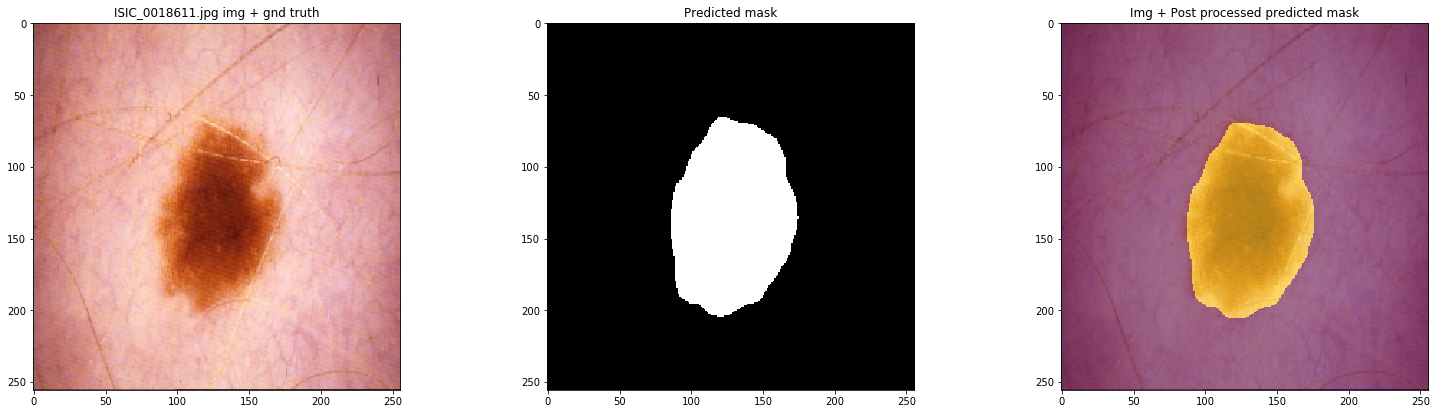

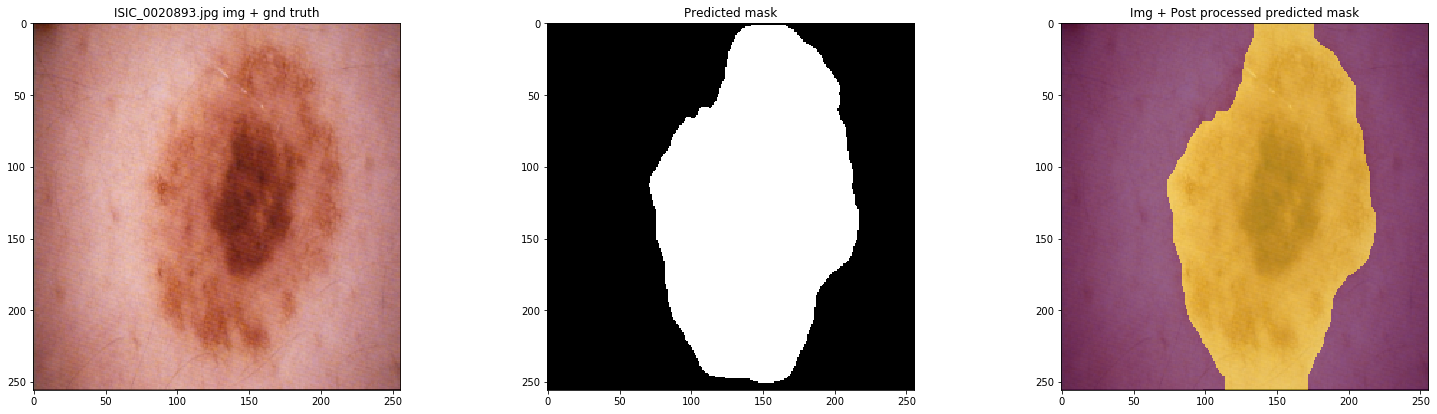

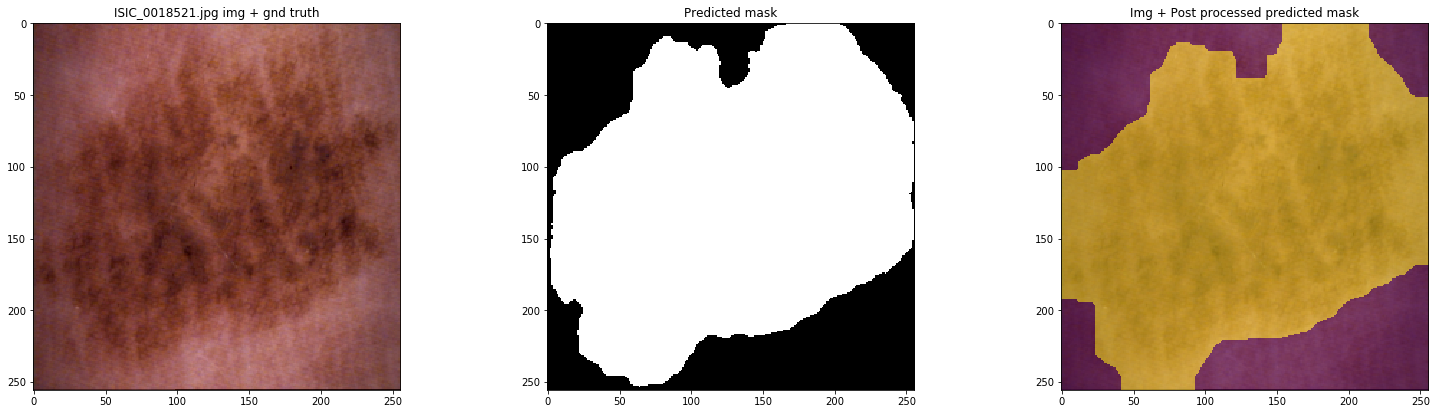

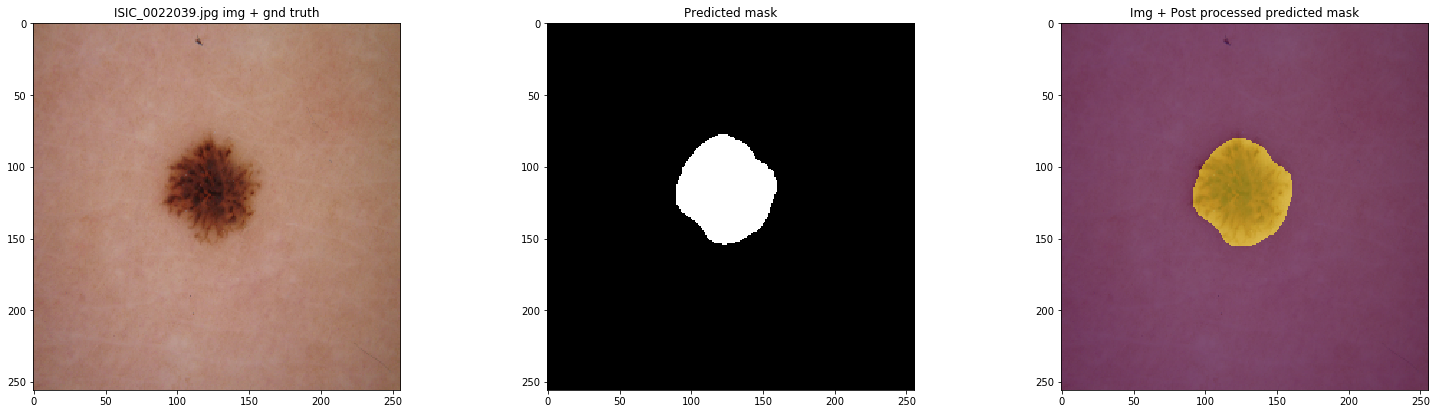

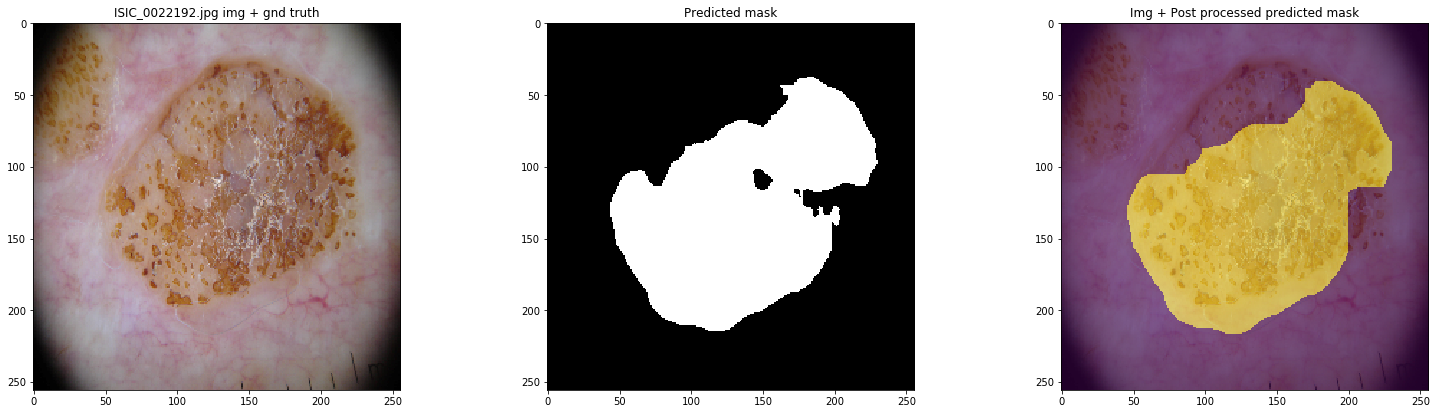

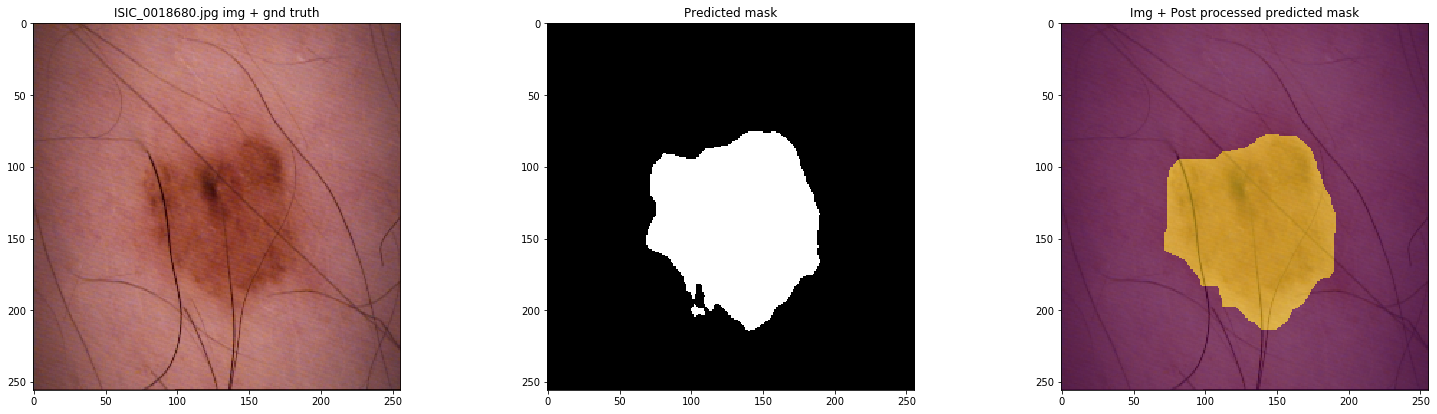

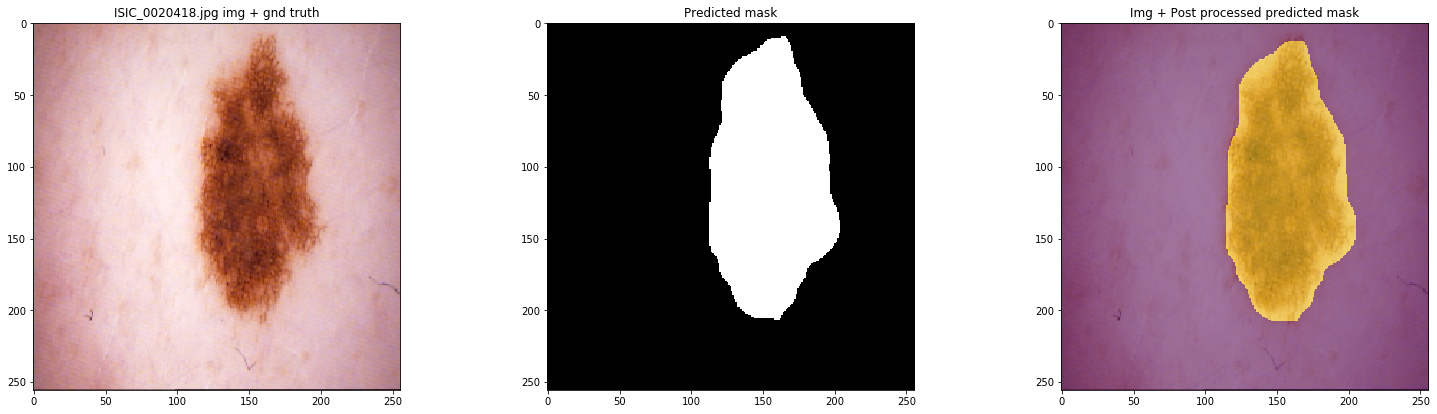

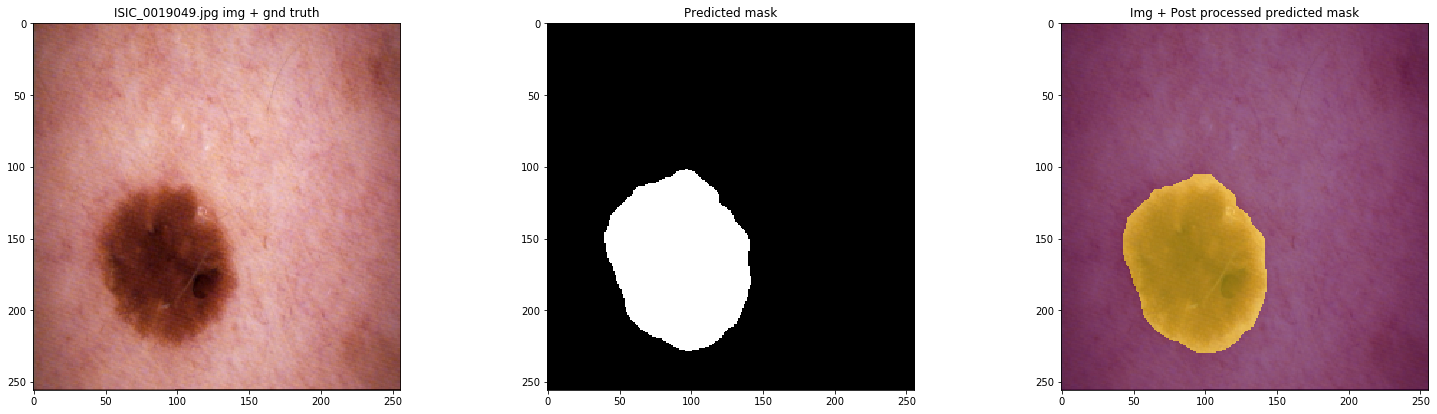

In [12]:
result = model.predict(x)
result2 = [];
for i in range(0, len(result)):
    result2.append(cv2.threshold(result[i], 0.5, 1, cv2.THRESH_BINARY)[1])
result = result2

op_kernel = np.ones((10,10),np.uint8)
cl_kernel = np.ones((20,20),np.uint8)

for i in range(0,len(result)):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.set_size_inches(25, 10.5)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[i])
    ax.set_title(name[i] + " img + gnd truth")
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(result[i], (image_size, image_size)), cmap="gray")
    ax.set_title("Predicted mask")
    
    ax = fig.add_subplot(1, 3, 3)
    mod_img = cv2.morphologyEx(result[i], cv2.MORPH_OPEN, op_kernel)
    mod_img = cv2.morphologyEx(mod_img, cv2.MORPH_CLOSE, cl_kernel)

    ax.imshow(x[i])
    ax.imshow(np.reshape(mod_img, (image_size, image_size)), alpha=0.5)
    ax.set_title("Img + Post processed predicted mask")